<a href="https://colab.research.google.com/github/mrisong/GeospatialML/blob/cloud_cover_detection_masking/CloudCoverDetectionMasking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install xarray
%pip install xarray-spatial
%pip install rasterio
%pip install transformers
%pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 58.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
tensorflow 2.14.0 requires numpy>=1.23.5, but you have numpy 1.23.4 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
import xarray
import xrspatial.multispectral as ms
import matplotlib.pyplot as plt
import rasterio
import pyproj
import time

from typing import List
from transformers import SegformerConfig, SegformerImageProcessor, SegformerForSemanticSegmentation
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.optim as optim
import torch.nn.utils.prune as prune
import evaluate

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

data_dir = "/content/gdrive/My Drive/CloudCoverData/"
feature_dir = f"{data_dir}train_features/"
label_dir = f"{data_dir}train_labels/"

meta_data = pd.read_csv(f"{data_dir}train_metadata.csv")

bands = ["B02", "B03", "B04", "B08"]

Mounted at /content/gdrive


Anlaysing the data...

It is observed that the given meta file of this dataset contains chip_ids, corresponding location, date and time of the images, and the location path on cloud

In [ ]:
meta_data.head()

,chip_id,location,datetime,cloudpath
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp
1,adwu,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwu
2,adwz,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwz
3,adxp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adxp
4,aeaj,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/aeaj


Datatype of columns in the meta data file

In [ ]:
# For each column in the meta data print its datatype
for col in meta_data:
    print(f"{col} datatype: {type(meta_data[col].iat[0])}")

chip_id datatype: <class 'str'>
location datatype: <class 'str'>
datetime datatype: <class 'str'>
cloudpath datatype: <class 'str'>


Checking for missing data in the meta file....

There is no null value in the meta data file

In [ ]:
meta_data.isnull().values.any()

False

Variation by location...

This shows non-uniform distribution of the images over different location

In [ ]:
# Group the dataset by location and extract number of chips for each location
location_counts = meta_data.groupby("location")["chip_id"].nunique().sort_values(ascending=False)

# print 10 random locations and number of corresponding chips
location_counts.sample(n=10)

location
Bor                         167
Chingola                    321
Santa Cruz do Sul           124
Tunis                       132
Bahir Dar                   174
South Africa                 29
Vitoria                     143
Australia - Central West    132
Alto Hama                    10
Morocco                       4
Name: chip_id, dtype: int64

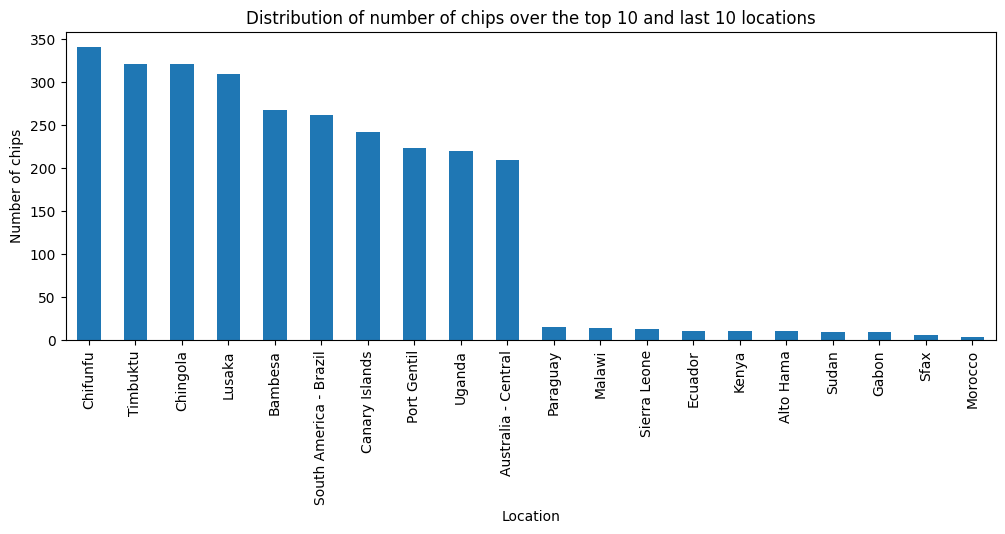

In [ ]:
# Visualise how the chips vary by location
# train_location_counts = meta_data.groupby("location")["chip_id"].nunique()
# Since, the interest here is the range of number of chips over different locations
# Choose the 10 locations with most and 10 locations with least number of chips
location_counts_difference = pd.concat([location_counts[0:10], location_counts[-11:-1]])

# Plot to visualise the same variation
plt.figure(figsize=(12, 4))
location_counts_difference.plot(kind="bar")
plt.xlabel("Location")
plt.ylabel("Number of chips")
plt.title("Distribution of number of chips over the top 10 and last 10 locations")
plt.show()

Variation by time...
Over the years also, there is a non-uniform distribution of the images.

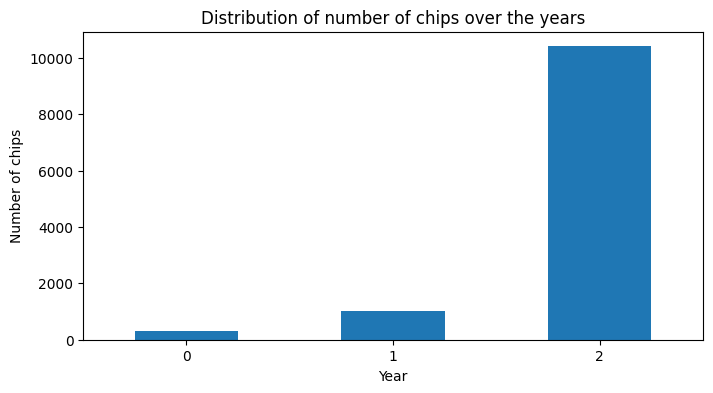

In [ ]:
# Visualise how the chips vary by year
# First separate the year from datetime stamp
meta_data["datetime"] = pd.to_datetime(meta_data["datetime"])
meta_data["year"] = meta_data.datetime.dt.year

# Group by the years
time_counts = meta_data.groupby("year")["chip_id"].nunique().sort_index().reset_index(name ='chip_count')

# Plot the distribution of number of chips with year
plt.figure(figsize=(8, 4))
time_counts['chip_count'].head(20).plot(kind="bar")
plt.xticks(rotation=0)
plt.xlabel("Year")
plt.ylabel("Number of chips")
plt.title("Distribution of number of chips over the years")
plt.show()

Distribution over a specific location at a specific time

In [ ]:
# Location and time and number of chips
location_time_count = meta_data.groupby(["location", "datetime"])[["chip_id"]].nunique().sort_values(by="chip_id", ascending=False).rename(columns = {'chip_id' : 'chip_count'})
location_time_count.head(10)

,,chip_count
location,datetime,
South America - Brazil,2020-09-06 15:02:37+00:00,261
Port Gentil,2020-09-08 09:50:58+00:00,223
Uganda,2019-04-25 08:29:37+00:00,220
Australia - Central,2020-08-11 01:24:00+00:00,209
Malabo,2020-09-06 10:00:03+00:00,206
Jimma,2020-05-31 08:07:58+00:00,201
Chifunfu,2020-04-29 08:20:47+00:00,197
South America - Suriname,2020-06-03 14:11:18+00:00,197
Isiro,2020-08-28 08:39:29+00:00,197


Looking at the meta data stored in the blue band image of some chip_id - 'jado'.

We note the image size here - 512×512

Each image also has CRS(Coordinate Reference System) information, which may be used to extract the corresponding latitude and longitude of each chip.

-------------------------
Note: The given dataset are observations from the Sentinel-2 mission, which is known to acquires data over land and coastal areas in a band of latitude extending from 56° South (Isla Hornos, Cape Horn, South America) to 82.8° North (above Greenland)[https://sentinel.esa.int/web/sentinel/missions/sentinel-2/observation-scenario]

In [ ]:
# Read the GEOTIFF file using 'rasterio' liberary
with rasterio.open(f"{feature_dir}jado/B02.tif") as im:
    meta = im.meta
    img_array = im.read(1)

print(meta)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 512, 'height': 512, 'count': 1, 'crs': CRS.from_epsg(32734), 'transform': Affine(10.0, 0.0, 785045.0,
       0.0, -10.0, 8253225.0)}


In [ ]:
# Print the image array in blue band of the sample chip
print(f"image array: {img_array}")

image array: [[ 735  893 1094 ...  959  945 1016]
 [ 688  709  683 ...  838  886  829]
 [ 601  570  480 ...  798  903 1066]
 ...
 [ 163  185  252 ...  401  554  525]
 [ 197  225  249 ...  466  419  406]
 [ 267  249  245 ...  447  377  424]]


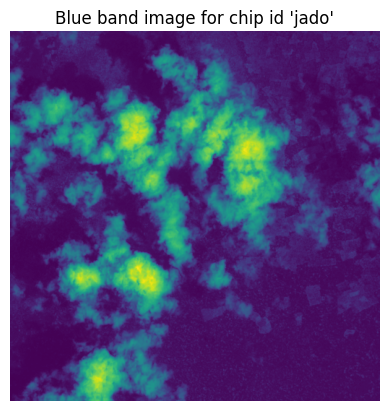

In [ ]:
# Display the image in blue band of the sample chip
plt.imshow(img_array)
plt.axis("off")
plt.title(f"Blue band image for chip id 'jado'")
plt.show()

Function to find missing value in a given band of a given chip

In [ ]:
def missing_info(feature_dir, chip_id, band):
  '''
  Input-
  feature_dir: path to feature directory,
  chip_id: the corresponding chip_id for which the missing data information is required,
  band: wavelength band id
    The function reads the image as an array and prints the total number of missing values in the array
  '''
  with rasterio.open(f"{feature_dir}{chip_id}/{band}.tif") as im:
    img_array = im.read(1)
  print(f"Checking for missing values:\nnumber of missing values = {np.isnan(img_array).sum()}")

# Find missing values in a green band of a sample chip
missing_info(feature_dir, 'kguo', 'B03')

Checking for missing values:
number of missing values = 0


Extract the latitude/longitude information from the image

In [ ]:
def coord_info(feature_dir, chip_id, band='B02'): #Band id is kept optional because the coordinates does not depend on the wavelength band of the image
  '''
  Input-
  feature_dir: path to feature directory,
  chip_id: the corresponding chip_id for which the coordinate information is required,
  band: wavelength band id(optional)
    The function extract the coordinate information in terms of range of latitude and longitude covered in the image
    as well as that of the centre of the image.
    This information is then displayed on the screen
  '''
  with rasterio.open(f"{feature_dir}{chip_id}/{band}.tif") as im:

    # Extract the latitude longitude information for the image
    centre_long, centre_lat = im.lnglat()
    bounds = im.bounds

  # create a converter starting with the current projection
  current_crs = pyproj.CRS(meta["crs"])
  crs_transform = pyproj.Transformer.from_crs(current_crs, current_crs.geodetic_crs)

  # extract left, bottom, right and top coordinates
  left, bottom, right, top = crs_transform.transform_bounds(*bounds)
  print(f"Latitute Longitude of the location of the image:\nStart: ({left}, {bottom})\nCentre: {centre_lat, centre_long} \nEnd: ({right}, {top})")
  print(f"Image location as per the meta data file is: {meta_data.loc[meta_data['chip_id'] == chip_id]['location'].to_numpy()[0]}")

# Find coordinates of a sample chip
coord_info(feature_dir, 'mbzl')

Latitute Longitude of the location of the image:
Start: (-1.1996198186231863, 23.535423223298455)
Centre: (-1.1764604900016324, -78.44156807441108) 
End: (-1.153301802115128, 23.581441005855375)
Image location as per the meta data file is: Riobamba


Add columns of image path for each band and the label path corresponding to each chip.
This is done for ease of extracting the images and labels.

In [ ]:
def add_paths(df, feature_dir, label_dir, bands=bands):
  '''
  Input-
  df: dataframe containing meta data,
  feature_dir: path to feature directory,
  label_dir: label directory,
  bands: list of wavelength band id
    add paths corresponding to each chip, in the dataframe containing meta data;
    paths for the each band and label for that chip is added
  '''
  for band in bands:
    df[f"{band}_path"] = feature_dir + df['chip_id'] + f"/{band}.tif"
  df["label_path"] = label_dir + df['chip_id'] + ".tif"
  return df

meta_data = add_paths(meta_data, feature_dir, label_dir)
print('Updated dataframe with the image band and label locations path:')
meta_data.head()

Updated dataframe with the image band and label locations path:


,chip_id,location,datetime,cloudpath,year,B02_path,B03_path,B04_path,B08_path,label_path
0,adwp,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwp,2020,/content/gdrive/My Drive/CloudCoverData/train_...,/content/gdrive/My Drive/CloudCoverData/train_...,/content/gdrive/My Drive/CloudCoverData/train_...,/content/gdrive/My Drive/CloudCoverData/train_...,/content/gdrive/My Drive/CloudCoverData/train_...
1,adwu,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwu,2020,/content/gdrive/My Drive/CloudCoverData/train_...,/content/gdrive/My Drive/CloudCoverData/train_...,/content/gdrive/My Drive/CloudCoverData/train_...,/content/gdrive/My Drive/CloudCoverData/train_...,/content/gdrive/My Drive/CloudCoverData/train_...
2,adwz,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwz,2020,/content/gdrive/My Drive/CloudCoverData/train_...,/content/gdrive/My Drive/CloudCoverData/train_...,/content/gdrive/My Drive/CloudCoverData/train_...,/content/gdrive/My Drive/CloudCoverData/train_...,/content/gdrive/My Drive/CloudCoverData/train_...
3,adxp,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adxp,2020,/content/gdrive/My Drive/CloudCoverData/train_...,/content/gdrive/My Drive/CloudCoverData/train_...,/content/gdrive/My Drive/CloudCoverData/train_...,/content/gdrive/My Drive/CloudCoverData/train_...,/content/gdrive/My Drive/CloudCoverData/train_...
4,aeaj,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/aeaj,2020,/content/gdrive/My Drive/CloudCoverData/train_...,/content/gdrive/My Drive/CloudCoverData/train_...,/content/gdrive/My Drive/CloudCoverData/train_...,/content/gdrive/My Drive/CloudCoverData/train_...,/content/gdrive/My Drive/CloudCoverData/train_...


Visualise True Color Images

In [ ]:
# Functions to display True color images
def make_DataArray(path):
  '''
  Input-
  path: image path
  Return-
        numpy array of the image
    xarray library is used to extract the array from the image
  '''
  img_array = np.array(Image.open(path))
  return xarray.DataArray(img_array, dims = ['y', 'x'])

def true_color_img(chip_id, data_path = feature_dir):
  '''
  Input-
      chip_id: the corresponding chip_id for which a true color image is required,
      data_path: path of the directory where the chips are located
  Return-
      IoU: true color image
    use the Red, Green, Blue band image paths
    the corresponding images are extracted and combined to create a true color image of the given chip_id
  '''
  chip_path = f"{data_path}{chip_id}/"
  red = make_DataArray(f"{chip_path}B04.tif")
  green = make_DataArray(f"{chip_path}B03.tif")
  blue = make_DataArray(f"{chip_path}B02.tif")
  return ms.true_color(r=red, g=green, b=blue)

Display random chips and the corresponding masks

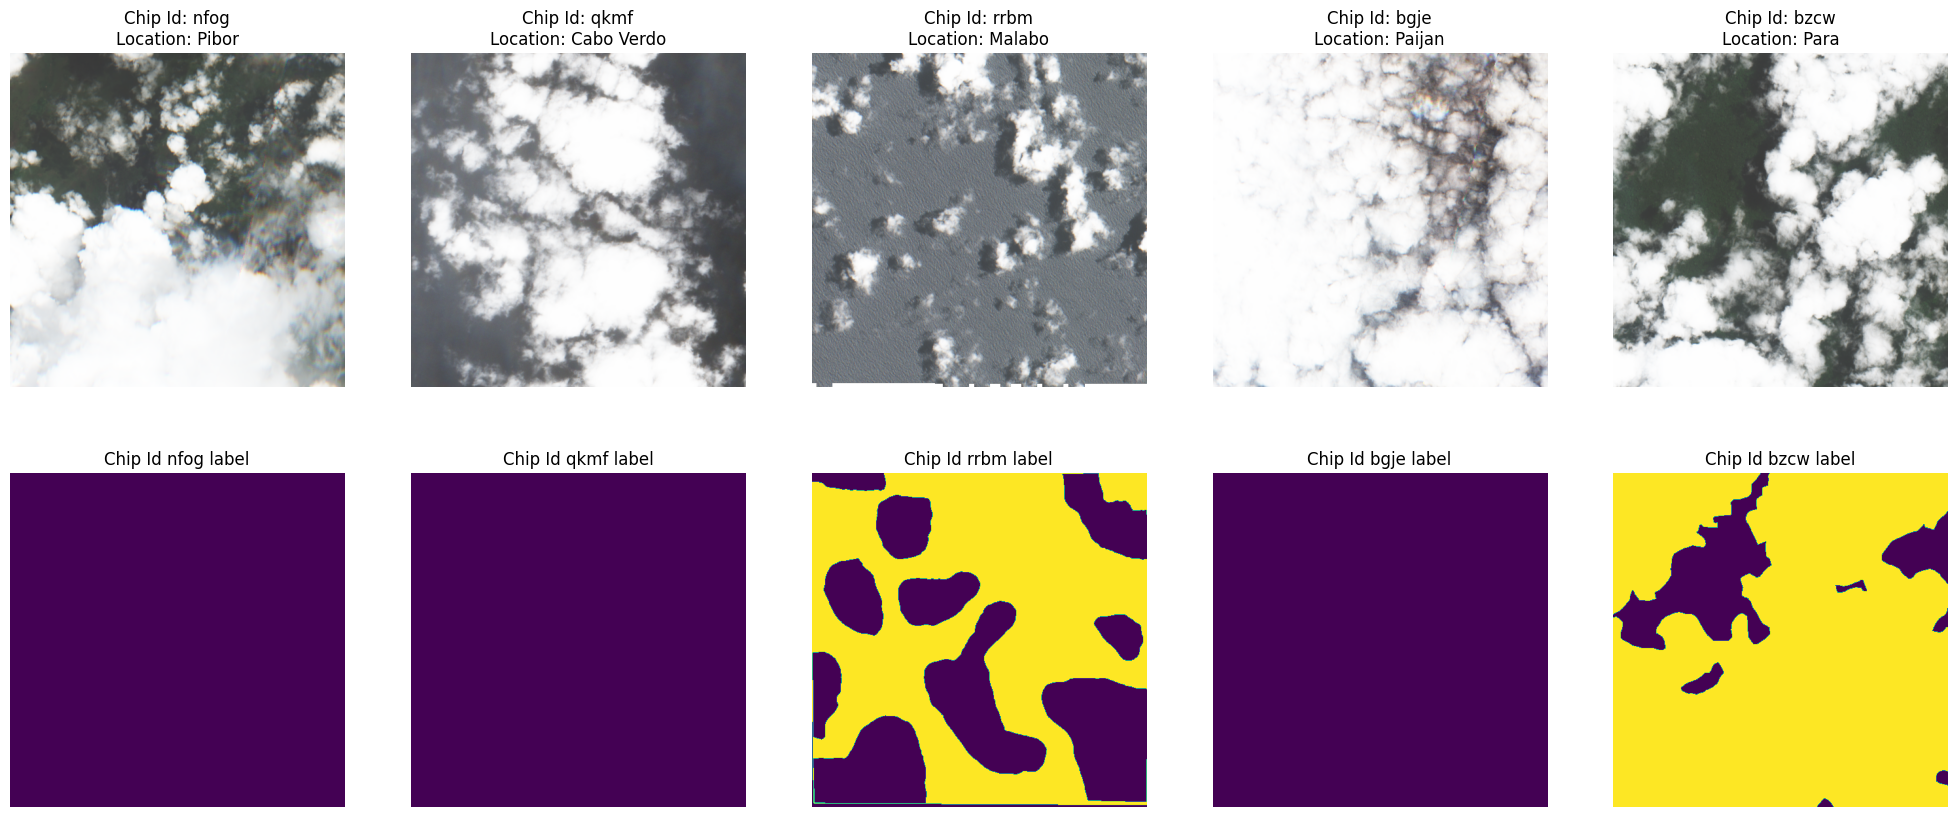

In [ ]:
# Use the functions in the previous cell and display 5 random chip images and labels

fig = plt.figure(figsize=(25, 10))

# display 5 images and masks
no_of_chips = 5

for i in range(1, no_of_chips+1):
  # sample random chips
    sample_chip = meta_data.sample().iloc[0]
    ax = fig.add_subplot(2, no_of_chips, i)
    ax.axis("off")
    ax.imshow(true_color_img(sample_chip.chip_id))
    ax.set_title(f"Chip Id: {sample_chip.chip_id}\nLocation: {sample_chip.location}")

    ax = fig.add_subplot(2, 5, i+no_of_chips)
    ax.axis("off")
    label = Image.open(sample_chip.label_path)
    ax.imshow(label)
    ax.set_title(f"Chip Id {sample_chip.chip_id} label")

# Preparation for model fine-tuning
The first step is to divide dataset into train, validation and test set.
We will assign 30% of the data set as test data. From remaining 70%, 30% shall be validation data and rest all shall be training data.

In [ ]:
print(f"Total numbers of chips= {meta_data['chip_id'].count()}")
no_of_test_data = round(meta_data['chip_id'].count() * 0.3)
print(f"Number of chips in Test dataset = {no_of_test_data}")
no_of_validation_data = round(meta_data['chip_id'].count() * 0.7 * 0.3)
print(f"Number of chips in Validation dataset = {no_of_validation_data}")
print(f"Number of chips in Train dataset= {meta_data['chip_id'].count()-no_of_test_data-no_of_validation_data}")

Total numbers of chips= 11748
Number of chips in Test dataset = 3524
Number of chips in Validation dataset = 2467
Number of chips in Train dataset= 5757


## Extracting the Test Data
We attempt to divide the dataset based on the locations. Random locations are selected and total number of chips contribution from those locations are counted. The number of locations are increased in each loop. As soon as we get the required number of chips, break the loop and select the corresponding locations for the test data.

Error and exception clause is used in this loop because it is possible that we don't get required number of chips as we keep on adding the locations. In such cases, we just restart from beginning.

In [ ]:
test_meta = pd.DataFrame(columns=meta_data.columns)
n_loc = 15

# 'iters' is used to keep a check on number of iterations
iters = 0

while True:
    try:
        random_locations = location_counts.sample(n=n_loc)
        no_of_chips = np.sum(random_locations.to_numpy())
        if no_of_chips in range(no_of_test_data-100, no_of_test_data+100):
            print(f"Number of Locations in the Test Dataset: {random_locations.nunique()}")
            print(f"Total number of chips in the Test Dataset: {no_of_chips}")
            print(f"Details of the selected locations:\n{random_locations}")
            break
        n_loc+=1
    except ValueError:
        n_loc=15
        iters+=1

        # Stop, if number of iterations reaches 20
        if iters == 20:
            print(f"Failed after {iters} iterations....\nIncrease the range for total number of chips required in the test data")
            break
        continue

for i in random_locations.index:
    next_row = meta_data.loc[meta_data.location == i, :]
    test_meta = pd.concat([test_meta, next_row])
    meta_data.drop(next_row.index, inplace=True)
location_counts = meta_data.groupby(["location"])[["chip_id"]].nunique()

Number of Locations in the Test Dataset: 20
Total number of chips in the Test Dataset: 3437
Details of the selected locations:
location
Kalamie                     156
Riobamba                    194
Malemba Nkulu               169
Alto Hama                    10
Rio Branco                  130
Lusaka                      309
Ethiopia                    171
Macapa                      177
Senanga                     159
Angola                       24
Canary Islands              242
Eswatini                    195
Monongue                    158
San Lorenzo                 196
Australia - Central West    132
Launceston                   86
South America - Brazil      261
Manaus                      176
Juba                        158
Paijan                      184
Bechar                      150
Name: chip_id, dtype: int64


## Extracting the Validation Data
Same process is repeated for creating the validation dataset.

In [ ]:
validation_meta = pd.DataFrame(columns=meta_data.columns)
n_loc = 10
iters = 0
while True:
    try:
        random_locations = location_counts.sample(n=n_loc)
        no_of_chips = np.sum(random_locations.to_numpy())
        if no_of_chips in range(no_of_validation_data-100, no_of_validation_data+100):
            print(f"Number of Locations in the Validation Dataset: {random_locations.nunique()[0]}")
            print(f"Total number of chips in the Validation Dataset: {no_of_chips}")
            print(f"Details of the selected locations:\n{random_locations}")
            break
        n_loc+=1
    except ValueError:
        n_loc=10
        iters+=1
        if iters == 20:
            print(f"Failed after {iters} iterations....\nIncrease the range for total number of chips required in the test data")
            break
        continue

for i in random_locations.index:
    next_row = meta_data.loc[meta_data.location == i, :]
    validation_meta = pd.concat([validation_meta, next_row])
    meta_data.drop(next_row.index, inplace=True)
location_counts = meta_data.groupby("location")["chip_id"].nunique()

Number of Locations in the Validation Dataset: 12
Total number of chips in the Validation Dataset: 2411
Details of the selected locations:
                        chip_id
location                       
Beira                       141
Cabo Verdo                  143
Santa Fe                    128
Timbuktu                    321
Jimma                       201
Bor                         167
Vitoria                     143
Australia - North West      187
Lodwar                      182
Chingola                    321
Gabon                         9
Porto Velho                 192
Madagascar                  159
Asmara nort                 117


## The Training Data

In [ ]:
print(f"Number of Locations in the Training Dataset: {location_counts.count()}")
print(f"Total number of chips in the Training Dataset: {np.sum(location_counts.to_numpy())}")
print(f"Details of the selected locations:\n{location_counts}")

Number of Locations in the Training Dataset: 46
Total number of chips in the Training Dataset: 5900
Details of the selected locations:
location
Addis Ababa                   138
Adelaide                      113
Adi Ramets                     90
Alexander Bay                 139
Angkor Wat                      2
Australia - Central           209
Bahir Dar                     174
Bambesa                       267
Bunbury                       119
Chibemba                      140
Chifunfu                      341
Cordoba                       104
DRC                            19
Ecuador                        11
Eritrea                       170
Georgetown                    178
Ghana                         162
Harare                        165
Isiro                         197
Kenya                          11
Kimberley                     140
Kolwezi                       166
Mahajanga                     159
Malabo                        206
Malawi                         14
Matadi

Summary of number of data points in each dataset after the train-validate-test split

In [ ]:
total = len(meta_data)+len(validation_meta)+len(test_meta)
print(f"Training data: {len(meta_data)}({round(len(meta_data)*100/total, 2)}%)")
print(f"Validation data: {len(validation_meta)}({round(len(validation_meta)*100/total, 2)}%)")
print(f"Test data: {len(test_meta)}({round(len(test_meta)*100/total, 2)}%)")

Training data: 5900(50.22%)
Validation data: 2411(20.52%)
Test data: 3437(29.26%)


## Creating Dataset
Create custom Dataset by importing PyTorch Dataset class for further processing.

In [ ]:
class CloudDataset(Dataset):
  def __init__(self, data_df: pd.DataFrame,
               bands: List[str]=bands):
    '''
    Construct Dataset type class
    '''
    self.data = data_df
    self.bands = bands
  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx: int):
    img = self.data.loc[idx]
    band_stack = []
    for band in self.bands:
      with rasterio.open(img[f"{band}_path"]) as b:
        next_band = b.read(1).astype("float32")
      band_stack.append(next_band)

    feature_array = np.stack(band_stack, axis = -1)
    feature_array = np.transpose(feature_array, [2, 0, 1])

    l_path = self.data.loc[idx].label_path
    with rasterio.open(l_path) as l:
      label_array = l.read(1).astype("float32")

    item = {"chip_id": img.chip_id,
            "image": feature_array,
            "label": label_array}
    return item

## Modify the pre-trained model
Update the number of input channels of the pre-trained dataset from 3 to 4 - consistent with the available dataset

In [ ]:
def modifiedSegformer():
  '''
  Return-
      model: a segformer model
    The Segformer model is modified by updating the number of input channels to 4, corresponding to the given multispectral satellite image dataset
    The input image size is same as that required by the model
  '''
  n_channels = 4

  # Get pretrained model
  segformer_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

  # Copy the configuration of pretrained model
  new_config = segformer_model.config

  # Modify config's values
  new_config.num_channels=n_channels

  # Instantiate new (randomly initialized) model
  new_model = SegformerForSemanticSegmentation(new_config)

  #Substitute first layer of the pretrained model with the modified one
  segformer_model.segformer.encoder.patch_embeddings[0] = new_model.segformer.encoder.patch_embeddings[0]

  return segformer_model.to(device)

##Functions to Evaluate Performance Metrics

In [ ]:
def prfmnc_metric(tp, fp, fn, tn):
  '''
  Input-
      tp: Total True Positives over entire validation dataset,
      fp: Total False Positives over entire validation dataset,
      fn: Total False Negatives over entire validation dataset,
      tn: Total True Negatives over entire validation dataset,
  Return-
      IoU: Intersection over Union,
      dice: Dice Coefficient,
      acc: Accuracy,
      precision: Precision,
      recall: Recall
    The input parameters are used to calculate the different evaluation metrics
  '''
  # a small term to avoid division by zero
  eps = 1e-5

  # Calculation of performance metrics
  IoU = (tp + eps) / (tp + fp + fn + eps)
  dice = (2 * tp + eps) / (2 * tp + fp + fn + eps)
  acc = (tp + tn + eps) / (tp + fp + fn + tn + eps)
  precision = (tp + eps) / (tp + fp + eps)
  recall = (tp + eps) / (tp + fn + eps)

  return IoU, dice, acc, precision, recall

def cnf_mtrx(pred, target):
  '''
  Input-
      pred: Predictions obtained from the model,
      target: Target values obtained from the label corresponding to the input image
    The prediction and input arrays are used to calculate the True Positives, False Positives, False Negatives and True Negatives
  '''
  for t, p in zip(target, pred):
    p = (p>0.5) # above 50% threshold the logit value may be considered as positive prediction
    actual = t.ravel()
    predicted = p.ravel()

    TP = np.sum(predicted * actual)
    FP = np.sum(predicted * (1 - actual))
    FN = np.sum((1 - predicted) * actual)
    TN = np.sum((1 - predicted) * (1 - actual))

  return (TP, FP, FN, TN)

##Functions to Plot the Progress to Monitor Validation Process

In [ ]:
def progress_plot(train_loss_list, val_loss_list, n_epochs):
  '''
  Input-
      train_loss_list: list of training loss recorded every second training epoch,
      val_loss_list: list of validation loss recorded every second training epoch,
      n_epochs: number of epochs

    The training lost and validation loss are both plotted in a single graph for ease of comparison.
    It shall be a useful tool to idetify underfit and overfit and monitor the progress during hyper paramter tuning
  '''
  plt.plot(range(2, n_epochs + 1, 2), train_loss_list, label = 'training loss')
  plt.plot(range(2, n_epochs + 1, 2), val_loss_list, label = 'validation loss')

  plt.xlabel('epoch number')
  plt.ylabel('loss')
  plt.title('progress of training and validation loss with epochs')
  plt.xticks(np.arange(0, n_epochs + 1, 2))
  plt.legend(loc='best')
  plt.show()

## Training and Evaluation functions

In [ ]:
def training(model, n_epochs=10, mode='Validation'):
  '''
  Input-
      model: model to be trained using the given dataset,
      n_epochs: number of epochs,
      mode: mode of training (Validation OR Train)
  Return-
      model: the model trained on the given dataset

    Training using Dataloader class of PyTorch.
    Also using Automatic Mixed Precision for increasing training speed
  '''
  model.train()

  # following two lists are used to keep track of training loss and validation loss used during hyperparameter tuning
  train_loss_list = []
  val_loss_list = []

  # keeping track of the training time
  since = time.time()

  # the training loop starts here...
  print("\n\n*************Model Training*************\n")
  for epoch in range(1, n_epochs+1):

    # keep track of the loss by adding losses in everybatch; finally it is divided by the number of batches to evaluate the average loss
    running_loss = 0

    print(f"\n-----------Epoch: {epoch}-----------")

    # loop through the each batch in the DataLoader
    for idx, batch in enumerate(trainDataloader):
      print(f"Training batch number {idx+1}...")

      # Training each batch in this loop
      x = batch["image"].to(device)
      y = batch["label"].long().to(device)

      # Computationally efficient operation compared to 'optimizer.zero_grad()'
      # as per 'https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html'
      optimizer.zero_grad(set_to_none=True)

      # Use Automatic Mixed Precision(AMP) for reducing the training time
      with torch.autocast(device_type=device, dtype=autocastType, enabled=ifcuda):
        outputs = model(x, y)
        loss, logits = outputs[0], outputs[1]

      # Use gradient scaling with AMP
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()

      # Add the loss for each batch
      running_loss += loss.item()

    # Print the average loss after each epoch
    print(f"\nTrain loss: {running_loss / len(trainDataloader)}")

    # Run validation every second epoch; this frequency may be reduced if the model is trained for higher number of epochs
    if epoch % 2 == 0 and mode == 'Validation':

      # Store the train loss and validation loss every second epoch
      train_loss_list.append(running_loss / len(trainDataloader))
      val_loss_list.append(evaluation(model, evalDataloader = valDataloader, mode = mode))

  # Plot the training progress using the validation loss and training loss recorded during training
  if mode == 'Validation':
    progress_plot(train_loss_list, val_loss_list, n_epochs)

  print(f"\n\nTraining time: {time.time()-since}s")
  print("*************Training Complete*************\n\n")

  # return the trained model
  return model

def evaluation(model, evalDataloader, mode = "Test"):
  '''
  Input-
      model: model to be evaluated on the given dataset,
      evalDataloader: the dataloader used to evaluate the model,
      mode: mode of evaluation (Validation OR Test)
  Return-
      loss: the evaluation loss
  '''

  # Access the global variable 'best_acc'; this variable shall be updated during hyper parameter tuning, if a model accuracy is found better than the global best
  global best_acc

  # Initialise the True Positive, False Positive, False Negative and True Negative
  total_TP = 0
  total_FP = 0
  total_FN = 0
  total_TN = 0

  model.eval()

  # print("\n\n*************Model Evaluation*************\n")
  with torch.no_grad():

    # total loss shall be calculated by adding the loss for each batch
    total_loss = 0

    # loop through all the batches in the given dataloader
    for idx, batch in enumerate(evalDataloader):

      x = batch["image"].to(device)
      y = batch["label"].long().to(device)

      outputs = model(x, y)
      loss, logits = outputs[0], outputs[1]

      # Add the loss for all the batches
      total_loss += loss.item()

      # Upsample the output logits using the label shape
      upsampled_logits = nn.functional.interpolate(
                      logits,
                      size=y.shape[-2:],
                      mode="bilinear",
                      align_corners=False
                  )

      predicted = upsampled_logits.argmax(dim=1)

      predictions=predicted.detach().cpu().numpy()
      references=y.detach().cpu().numpy()

      # Evaluate the True Positive, False Positive, False Negative and True Negative using the predicted and actual output
      TP, FP, FN, TN = cnf_mtrx(predictions, references)

      # Track the total for all the parameters
      total_TP += TP
      total_FP += FP
      total_FN += FN
      total_TN += TN

    # Calculate the mean loss by dividing total loss by the number of batches in the given data loader
    mean_loss = total_loss/len(evalDataloader)

    # Calculate all the performance metrices using the total True Positive, False Positive, False Negative and True Negative
    IoU, dice, acc, precision, recall = prfmnc_metric(total_TP,
                                                          total_FP,
                                                          total_FN,
                                                          total_TN)

    # Display the evaluation metrices
    print(f'{mode} loss: {mean_loss}\t\tMean IOU: {IoU}\t\tdice coefficient: {dice}')
    print(f'Accuracy: {acc}\t\tPrecision: {precision}\t\tRecall: {recall}')

  if mode == 'Test':
    pass
  # update the best accuracy if the model performs better than the best recorded so far
  elif best_acc < acc:
    best_acc = acc

  # print("\n*************Evaluation Complete*************\n")
  return mean_loss


Pruning Function - Apply 50% network pruning, to increase the training speed

In [ ]:
def model_prune(model):
  '''
  Input-
      model: model to be pruned
    All the modules with weight parameters are found;
    Global pruning is applied and L1 Unstructured pruning method is used to prune 50% parameters
  '''
  # The following modules conatin 'weight' parameter, thus, may be pruned
  parameters_to_prune = [(model.segformer.encoder.patch_embeddings[0].proj, 'weight'),
  (model.segformer.encoder.patch_embeddings[1].proj, 'weight'),
  (model.segformer.encoder.patch_embeddings[2].proj, 'weight'),
  (model.segformer.encoder.patch_embeddings[3].proj, 'weight'),
  (model.segformer.encoder.patch_embeddings[0].layer_norm, 'weight'),
  (model.segformer.encoder.patch_embeddings[1].layer_norm, 'weight'),
  (model.segformer.encoder.patch_embeddings[2].layer_norm, 'weight'),
  (model.segformer.encoder.patch_embeddings[3].layer_norm, 'weight')]

# Loop is used because these modules are available in different layer
# By just changing the index number we can asess these modules and their 'weight' parameters
  for j in range(2):
    for k in range(3):
      parameters_to_prune += [(model.segformer.encoder.block[k][j].attention.self.sr, 'weight'),
      (model.segformer.encoder.block[k][j].attention.self.layer_norm, 'weight')]
    for i in range(4):
      parameters_to_prune += [(model.segformer.encoder.block[i][j].layer_norm_1, 'weight'),
      (model.segformer.encoder.block[i][j].attention.self.query, 'weight'),
      (model.segformer.encoder.block[i][j].attention.self.key, 'weight'),
      (model.segformer.encoder.block[i][j].attention.self.value, 'weight'),
      (model.segformer.encoder.block[i][j].attention.output.dense, 'weight'),
      (model.segformer.encoder.block[i][j].layer_norm_2, 'weight'),
      (model.segformer.encoder.block[i][j].mlp.dense1, 'weight'),
      (model.segformer.encoder.block[i][j].mlp.dwconv.dwconv, 'weight'),
      (model.segformer.encoder.block[i][j].mlp.dense2, 'weight')]

  parameters_to_prune = tuple(parameters_to_prune)

  prune.global_unstructured(
      parameters_to_prune,
      pruning_method=prune.L1Unstructured,
      amount = 0.5
  )
  # print(model.segformer.encoder.block[i][j].mlp.dense2._forward_pre_hooks)

Create the Dataset and Dataloder

In [ ]:
# Because of resource constraint, currently using only 200 images for training, 120 for validation and 80 for test
trainDataset = CloudDataset(data_df = meta_data.reset_index(drop=True)[0:200],
                            bands = bands)
valDataset = CloudDataset(data_df = validation_meta.reset_index(drop=True)[0:120],
                          bands = bands)
testDataset = CloudDataset(data_df = test_meta.reset_index(drop=True)[0:80],
                          bands = bands)

batch_size = 8
trainDataloader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True, num_workers=2)
valDataloader = DataLoader(valDataset, batch_size=batch_size, num_workers=2)
testDataloader = DataLoader(testDataset, batch_size=batch_size, num_workers=2)

Define model, update the available device and define the evaluation metrics.

In [ ]:
# If cuda is available, set it as device;
# 'ifcuda' is used by gradscaler and autocast, which are used by automatic mixed precision
# 'autocastType' is also set here, because, torch.float16 is accepted only if cuda is ON
# Other option is to set it to 'torch.bfloat16', that way this extra variable may be removed

device, ifcuda, autocastType = ("cuda", True, torch.float16) if torch.cuda.is_available() else ("cpu", False, torch.bfloat16)
model = modifiedSegformer()

# Used for scaling gradients during training
scaler = torch.cuda.amp.GradScaler(enabled=ifcuda)

# Set the hyperparameters here
# Any new hyper-paramter which shall be tuned may be added as a key here
# and a possible value may be added as the dict value for the key
# The hyper-parameters which shall be tuned in the future are:
  # learning rate scheduler
  # momentum term in case of SGD optimiser
  # etc...
# The dataset may be trained and validated on different models to choose the best one for the given problem
hypr_params = {"learning_rate": 0.0001,
               "optimizer": optim.SGD
               }

n_epochs = 6


config.json:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/15.1M [00:00<?, ?B/s]

#Model Validation
Hyper-parameter tuning shall be performed as follows. It is demonstrated for learning rate and optimizer, but shall be extended for other hyper-parameters in future, including learning rate scheduler.

Tuning the learning rate.....
learning rate = 0.001


*************Model Training*************


-----------Epoch: 1-----------
Training batch number 1...
Training batch number 2...
Training batch number 3...
Training batch number 4...
Training batch number 5...
Training batch number 6...
Training batch number 7...
Training batch number 8...
Training batch number 9...
Training batch number 10...
Training batch number 11...
Training batch number 12...
Training batch number 13...
Training batch number 14...
Training batch number 15...
Training batch number 16...
Training batch number 17...
Training batch number 18...
Training batch number 19...
Training batch number 20...
Training batch number 21...
Training batch number 22...
Training batch number 23...
Training batch number 24...
Training batch number 25...

Train loss: 2.707819285392761

-----------Epoch: 2-----------
Training batch number 1...
Training batch number 2...
Training batch number 3...
Training batch number 4...
Training b

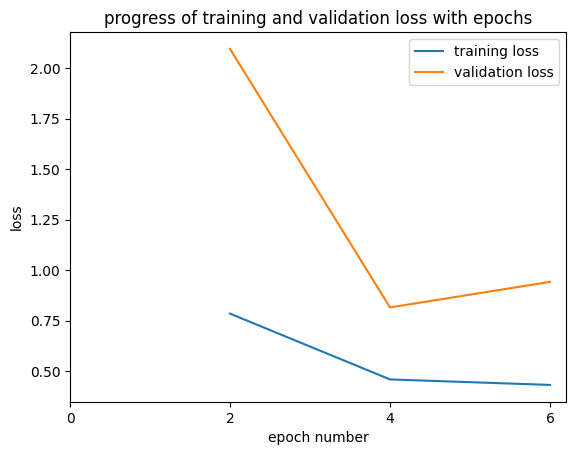



Training time: 2704.608828306198s
*************Training Complete*************


learning rate = 0.0001


*************Model Training*************


-----------Epoch: 1-----------
Training batch number 1...
Training batch number 2...
Training batch number 3...
Training batch number 4...
Training batch number 5...
Training batch number 6...
Training batch number 7...
Training batch number 8...
Training batch number 9...
Training batch number 10...
Training batch number 11...
Training batch number 12...
Training batch number 13...
Training batch number 14...
Training batch number 15...
Training batch number 16...
Training batch number 17...
Training batch number 18...
Training batch number 19...
Training batch number 20...
Training batch number 21...
Training batch number 22...
Training batch number 23...
Training batch number 24...
Training batch number 25...

Train loss: 3.4497068977355956

-----------Epoch: 2-----------
Training batch number 1...
Training batch number 2...
Training b

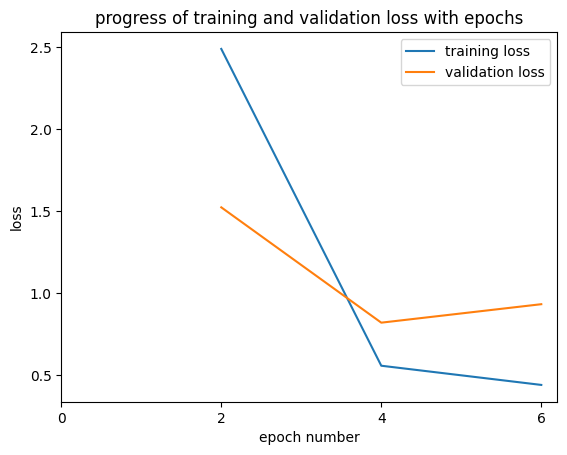



Training time: 1974.7211050987244s
*************Training Complete*************


The best of the validated learning rate is: 0.001


In [ ]:
# Tuning the learning rate using validation
best_acc = 0
print("Tuning the learning rate.....")

for hypr_params["learning_rate"] in [0.001, 0.0001]:# Add more possible values in this list, to validate the mdel against

  print(f"learning rate = {hypr_params['learning_rate']}")

  # reference accuracy, used to save the current best; this shall be used for comparison with the best accuracy found during this tuning
  ref_acc = best_acc

  # Assign the new model in each loop
  model = modifiedSegformer()

  # Assign the optimiser along with the parameters
  optimizer = hypr_params['optimizer'](model.parameters(), lr=hypr_params["learning_rate"], momentum=0.9)

  # Prune the model
  model_prune(model)


  # Model training; the best accuracy may be updated during validation, which is done after every 2 training epochs
  trained_model = training(model, n_epochs)

  # if the best accuracy is better than reference accuracy, then assign the current learning rate as the best learning rate
  if best_acc > ref_acc:
    best_param = hypr_params["learning_rate"]

# Assign the best parameter found during hyper parameter tuning
hypr_params["learning_rate"] = best_param
print(f"The best of the validated learning rate is: {best_param}")

The default optimizer is SGD, which is used for finding best learning rate in previous cell. Next, the model is validated against Adam optimizer. It may be easily extended to include other optimizers.

Tuning the Optimizer.....
Optimizer = Adam


*************Model Training*************


-----------Epoch: 1-----------
Training batch number 1...
Training batch number 2...
Training batch number 3...
Training batch number 4...
Training batch number 5...
Training batch number 6...
Training batch number 7...
Training batch number 8...
Training batch number 9...
Training batch number 10...
Training batch number 11...
Training batch number 12...
Training batch number 13...
Training batch number 14...
Training batch number 15...
Training batch number 16...
Training batch number 17...
Training batch number 18...
Training batch number 19...
Training batch number 20...
Training batch number 21...
Training batch number 22...
Training batch number 23...
Training batch number 24...
Training batch number 25...

Train loss: 1.8900549912452698

-----------Epoch: 2-----------
Training batch number 1...
Training batch number 2...
Training batch number 3...
Training batch number 4...
Training batch num

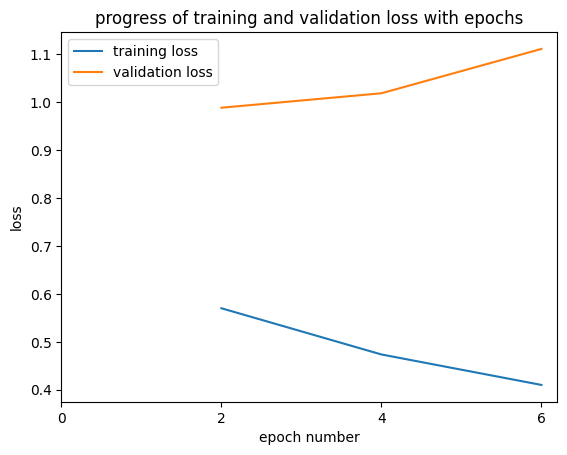



Training time: 1914.1630036830902s
*************Training Complete*************


The best of the validated optimizers is: Adam


In [ ]:
# Tuning the Optimizer using validation

# The best accuracy so far is assigned as the reference accuracy in each loop
ref_acc = best_acc
best_param = hypr_params["optimizer"]

print("Tuning the Optimizer.....")

for hypr_params["optimizer"] in [optim.Adam]: #Add optimizer names in this list, to validate the model against

  print(f"Optimizer = {hypr_params['optimizer'].__name__}")

  # Assign the new model
  model = modifiedSegformer()

  # Assign the optimiser along with the parameters
  optimizer = hypr_params['optimizer'](model.parameters(), lr=hypr_params["learning_rate"])

  # Prune the model
  model_prune(model)

  # Model training; the best accuracy may be updated during validation, which is done after every 2 training epochs
  trained_model = training(model, n_epochs)

  # if the best accuracy is better than reference accuracy, then assign the current optimiser as the best optimiser
  if best_acc > ref_acc:
    best_param = hypr_params["optimizer"]

# Assign the best parameter found during hyper parameter tuning
hypr_params["optimizer"] = best_param
print(f"The best of the validated optimizers is: {best_param.__name__}")

# Model Training
The model tuned through validation is shall be trained now

In [ ]:
# Because of resource constraint, currently using only 320 images shall be used for training - 200 from training set, 120 from validation set
trainDataset = CloudDataset(data_df = pd.concat([meta_data.reset_index(drop=True)[0:200], validation_meta.reset_index(drop=True)[0:120]], ignore_index=True),
                            bands = bands)

batch_size = 8
trainDataloader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True, num_workers=2)

model = modifiedSegformer()

# Assign the optimizer with model parameter
optimizer = hypr_params['optimizer'](model.parameters(), lr=hypr_params["learning_rate"])

# If the optimizer is SGD, assign the momentum value also. This itself is a tunable paramter, and its tuning shall be attempted in future
if hypr_params['optimizer'].__name__ == 'SGD':
  optimizer.momentum = 0.9

# Prune the model
model_prune(model)

# Now, the model is ready to be trained
trained_model = training(model, n_epochs, 'Train')



*************Model Training*************


-----------Epoch: 1-----------
Training batch number 1...
Training batch number 2...
Training batch number 3...
Training batch number 4...
Training batch number 5...
Training batch number 6...
Training batch number 7...
Training batch number 8...
Training batch number 9...
Training batch number 10...
Training batch number 11...
Training batch number 12...
Training batch number 13...
Training batch number 14...
Training batch number 15...
Training batch number 16...
Training batch number 17...
Training batch number 18...
Training batch number 19...
Training batch number 20...
Training batch number 21...
Training batch number 22...
Training batch number 23...
Training batch number 24...
Training batch number 25...
Training batch number 26...
Training batch number 27...
Training batch number 28...
Training batch number 29...
Training batch number 30...
Training batch number 31...
Training batch number 32...
Training batch number 33...
Training 

#Model Evaluation

In [ ]:
evaluation(trained_model, evalDataloader=testDataloader)

Test loss: 0.403291380405426		Mean IOU: 0.7696313422661818		dice coefficient: 0.8698211021514318
Accuracy: 0.8306705474859976		Precision: 0.9623563248229541		Recall: 0.7935202828278959


0.403291380405426

# Quantization
Apply Eager Mode, Post-Training, Dynamic Quantization

In [ ]:
import torch.ao.quantization.quantize_fx as quantize_fx
from torch.ao.quantization import QConfigMapping
from torch.utils.mobile_optimizer import optimize_for_mobile
import os

In [ ]:
model_to_quantize = trained_model.to("cpu")
model_quantised = torch.ao.quantization.quantize_dynamic(
    model_to_quantize,  # the original model
    {torch.nn.Linear},  # Dynamically quantize the layers in this set
    dtype=torch.qint8)

Compare the size of the quantized model with the original trained model

In [ ]:
def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    print(f"model: {label}\t Size (KB): {size/1e3}")
    os.remove('temp.p')
    return size

# compare the sizes
original = print_size_of_model(model_to_quantize,"fp32")
quantized = print_size_of_model(model_quantised,"int8")

print(f"{original/quantized} times smaller")

model: fp32	 Size (KB): 28321.546
model: int8	 Size (KB): 11785.906
2.403001177847507 times smaller


Following method is tried to script and deploy a lite version. This scripting is currently not supported by Pytorch.

Alternative methods shall be worked out soon...

In [ ]:
# scripted_quantized_model = torch.jit.script(model_quantised)
# scripted_quantized_model.save("segformer_cloud_quantized_script.pt")

# optimized_scripted_quantized_model = optimize_for_mobile(scripted_quantized_model)
# optimized_scripted_quantized_model.save("segformer_cloud_optimized_quantized_script.pt")

# optimized_scripted_quantized_model._save_for_lite_interpreter("segformer_cloud_optimized_quantized_script_lite.ptl")
# ptl = torch.jit.load("segformer_cloud_optimized_quantized_script_lite.ptl")